# Risk Bucketing
One of the most common use cases for machine learning in financial services is estimating the probability of default on a loan.

Risk bucketing refers to the process of grouping borrowers with similar creditworthiness.  Treating all borrowers equally will generally result in poor predictions, as the model cannot capture entirely different characteristics of the data all at once.  By dividing borrowers into different groups based on risk characteristics, risk bucketing enables us to make accurate predictions.

Risk bucketing is a good example of an unsupervised clustering problem.  The K-means algorithm (which we use here) is one way we can perform risk bucketing.

However, there is one major issue: how do we know the optimal number of risk buckets (clusters) to use for a given set of data/borrowers?  This notebook demonstrates a number of techniques for calculating the optimal number of clusters:
- The Elbow Method
- Silhouette Scores
- Gap Analysis

In [134]:
import pandas as pd

Python 3.7.10


Our data source is the well-known German Credit Risk data.

In [135]:
credit = pd.read_csv(
    "s3://sagemaker-sample-files/datasets/tabular/"
    + "uci_statlog_german_credit_data/german_credit_data.csv"
)
credit.head()

,existingchecking,duration,creditamount,savings,employmentsince,status_sex,age,housing,existingcredits,job,dependents,risk
0,none,6,1169,unknown,7+ years,male:single,67,own,2,skilled employee / official,1,low risk
1,little,48,5951,little,1 to 4 years,female:divorced/separated/married,22,own,1,skilled employee / official,1,high risk
2,no account,12,2096,little,4 to 7 years,male:single,49,own,1,unskilled,2,low risk
3,none,42,7882,little,4 to 7 years,male:single,45,for free,1,skilled employee / official,2,low risk
4,none,24,4870,little,1 to 4 years,male:single,53,for free,2,skilled employee / official,2,high risk


We drop the numeric columns *dependents* and *existingcredits* as we are not going to use them.

In [91]:
credit.drop(["dependents", "existingcredits"], inplace=True, axis=1)

Convert the *job* column, which contains categorical values, into a numerical one that contains ordinal values.

In [92]:
credit["job"].replace(
    [
        "unemployed",
        "unskilled",
        "skilled employee / official",
        "management / highly skilled",
    ],
    [0, 1, 2, 3],
    inplace=True,
)

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams["figure.figsize"] = (10, 6)

Drop all columns except for the following (numeric) ones:
- Age
- Job (ordinal ranging from 0=unemployed to 3=management / highly skilled)
- Credit amount
- Duration (the duration of the loan in months)

In [94]:
numerical_credit = credit.select_dtypes(exclude="O")
numerical_credit.head()

,duration,creditamount,age,job
0,6,1169,67,2
1,48,5951,22,2
2,12,2096,49,1
3,42,7882,45,2
4,24,4870,53,2


Plotting histograms of these four features, we can see that they are all positively skewed.

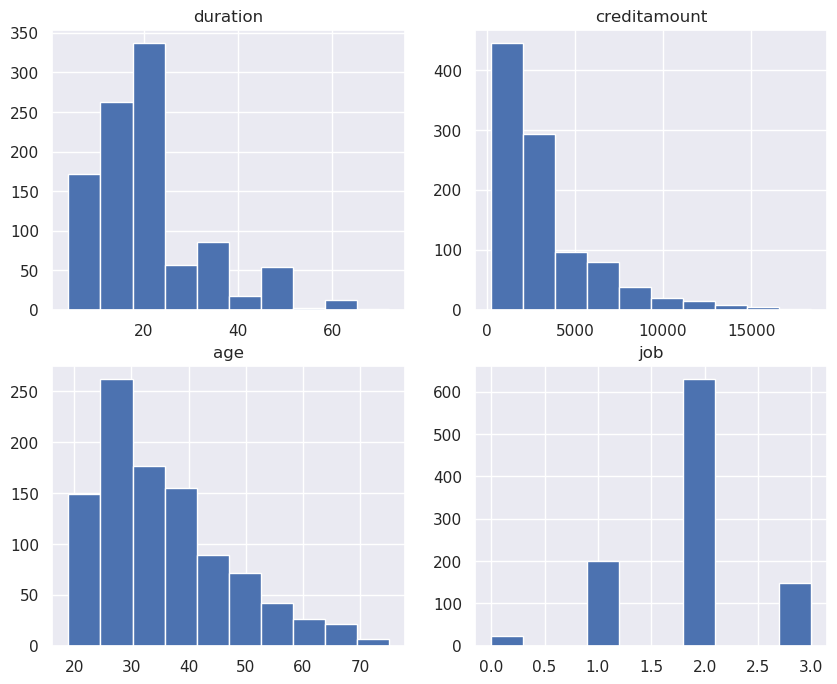

In [95]:
plt.figure(figsize=(10, 8))
k = 0
cols = numerical_credit.columns
for i, j in zip(range(len(cols)), cols):
    k += 1
    plt.subplot(2, 2, k)
    plt.hist(numerical_credit.iloc[:, i])
    plt.title(j)
plt.show()

## The Elbow Method
Our first method for estimating the optimal number of clusters is the Elbow Method.  This involves calculating *inertia* which is the sum of the squared distances of observations from their closest centroid.

If we plot inertia against number of clusters (k) we can see an *elbow* (i.e. the curve starts to flatten out) around the value of k=4.  This is an indication that increasing the number of clusters is undesirable (when traded-off against increased complexity).

Here we are using the KMeans algorithm from Sklearn, as it provides inertia as part of its output. 

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [97]:
scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)

In [98]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_credit)
    inertia.append(kmeans.inertia_)

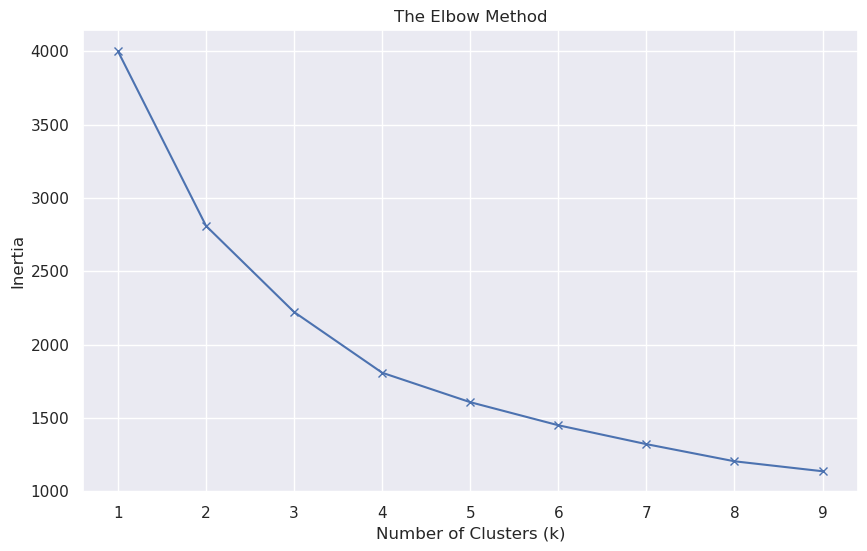

In [99]:
plt.plot(range(1, 10), inertia, "bx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("The Elbow Method")
plt.show()

## Silhouette Scores
Silhouette scores take a value between 1 and -1.  A value of 1 indicates an observation that is close to the correct centroid and correctly classified.  A value of -1 shows that the observation is not correctly clustered.

The strength of the Silhouette Score is that it takes into account both the intra-cluster distance (how close observations are to their centroid) and the inter-cluster distance (how far apart the centroids are).  The formula for Silhouette Score is as follows:
\begin{equation}
Silhouette = \frac{x - y}{max(x, y)}
\end{equation}
where x is the mean inter-cluster distance between clusters, and y is the mean intra-cluster distance.

In this case, we can see that the peak Silhouette score occurs when the number of clusters (k) is 2.  This implies that it is not worth using more than 2 clusters.

In [100]:
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [101]:
silhouette_scores = []
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(scaled_credit)
    centers = clusterer.cluster_centers_
    silhouette_scores.append(silhouette_score(scaled_credit, preds))

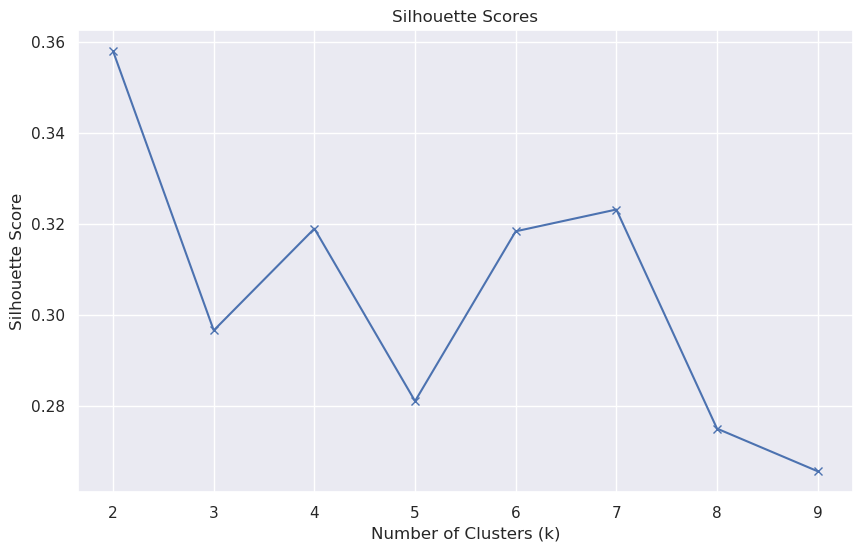

In [102]:
plt.plot(range(2, 10), silhouette_scores, "bx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores")
plt.show()

## Gap Analysis
Our final approach is *gap analysis*.  This is based on the work of <a href="https://hastie.su.domains/Papers/gap.pdf">Tibshirani et al. (2001)</a> which proposes finding the optimal number of clusters
based on a reference distribution.

Our data consists of $n$ independent observations of $p$ features.  The Euclidean distance between observations $i$ and $i'$ is:
\begin{equation}
d_{ii'} = \sum_{j} (x_{ij} - x_{i'j})^2
\end{equation}

And the sum of all pairwise distances for points in cluster r is:
\begin{equation}
D_{r} = \sum_{i,i' \in C_{r}} d_{ii'}
\end{equation}

Then the pooled, within-cluster sum of squares around the cluster mean is:
\begin{equation}
W_{k} = \sum_{r=1}^k \frac{1}{2n_{r}}D_{r}
\end{equation}

The idea of this approach is to standardize the graph of $log(W_{k})$ by comparing it with its expectation under an appropriate null reference distribution of the data.  The expectation of $W_{k}$ is approximately
\begin{equation}
log(pn/12) - (2/p)log(k) + constant
\end{equation}

In [103]:
pip install gap-stat


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Import the OptimalK module for calculating the gap statistic.

In [104]:
from gap_statistic.optimalK import OptimalK

Calculate the gap statistic for various values of $k$ using parallelization.

In [105]:
optimalK = OptimalK(n_jobs=8, parallel_backend="joblib")
n_clusters = optimalK(scaled_credit, cluster_array=np.arange(1, 10))

In [106]:
gap_result = optimalK.gap_df
gap_result.head()

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,1.0,0.901966,5858.189797,90.376405,0.010614,6765.259847,-0.077159,6627.318626
1,2.0,1.013316,4932.605532,227.450445,0.034191,5701.734361,0.026400,5540.422665
2,3.0,1.014603,3908.279700,147.301521,0.027686,4516.096833,0.027837,4456.587890
3,4.0,1.031957,3497.320211,209.960031,0.045191,4045.628401,-0.079289,4023.969088
4,5.0,1.125069,3400.348980,60.091121,0.013824,3926.997857,0.120923,3821.284378


If we plot the resulting gap values, we observe a sharp increase up to the point where the gap value reaches its peak.  In this case this corresponds to 5 clusters.  The analysis suggests that this is the optimal number for clustering.

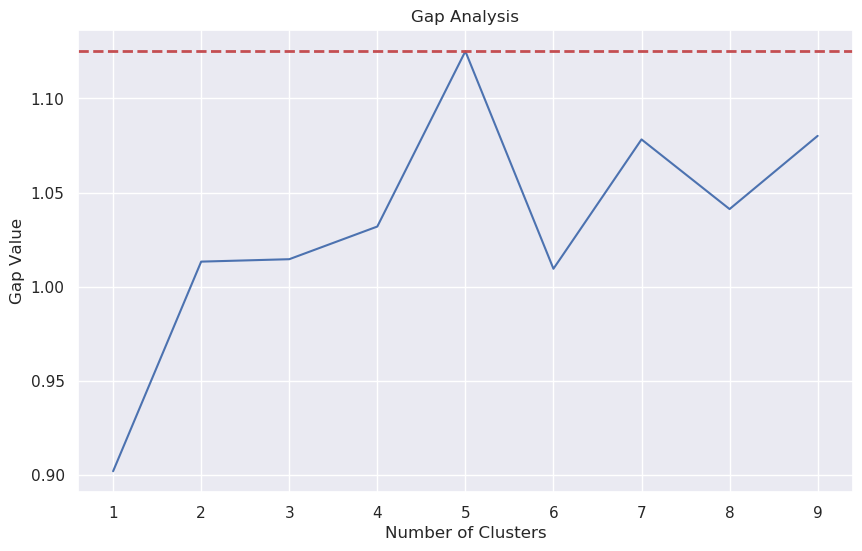

In [107]:
plt.plot(gap_result.n_clusters, gap_result.gap_value)
min_ylim, max_ylim = plt.ylim()
plt.axhline(np.max(gap_result.gap_value), color="r", linestyle="dashed", linewidth=2)
plt.title("Gap Analysis")
plt.xlabel("Number of Clusters")
plt.ylabel("Gap Value")
plt.show()

## K-Means Clustering 
Due to their differing approaches, the three analyses above all provide a different value for the optimal number of clusters.  It will require some trial and error to determine which is indeed the optimal number of clusters.

For example, let us proceed on the basis that the optimal number of clusters is two (as suggested by the *Silhouette Scores*).

We perform K-Means clustering to separate our observations into two.

In [108]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(scaled_credit)

Finally, we generate some plots to visualize the clusters in two dimensions.  The plots show the observations (with color indicating the assigned cluster).  Black crosses are used to show the position of the two centroids.

The first plot shows the relationship between the *age* and *credit* features.  Here we can see that *age* is the more dispersed feature, with the centroids located vertically inline.

The second plot considers two continuous features: *credit* and *duration*.  Here we observe two clearly separated clusters.  This suggests that the *duration* feature is more volatile when compared with the *credit* feature.

Finally, the third plot examines the relationship between *age* and *duration*.  It turns out that there are many overlapping observations across these two features.

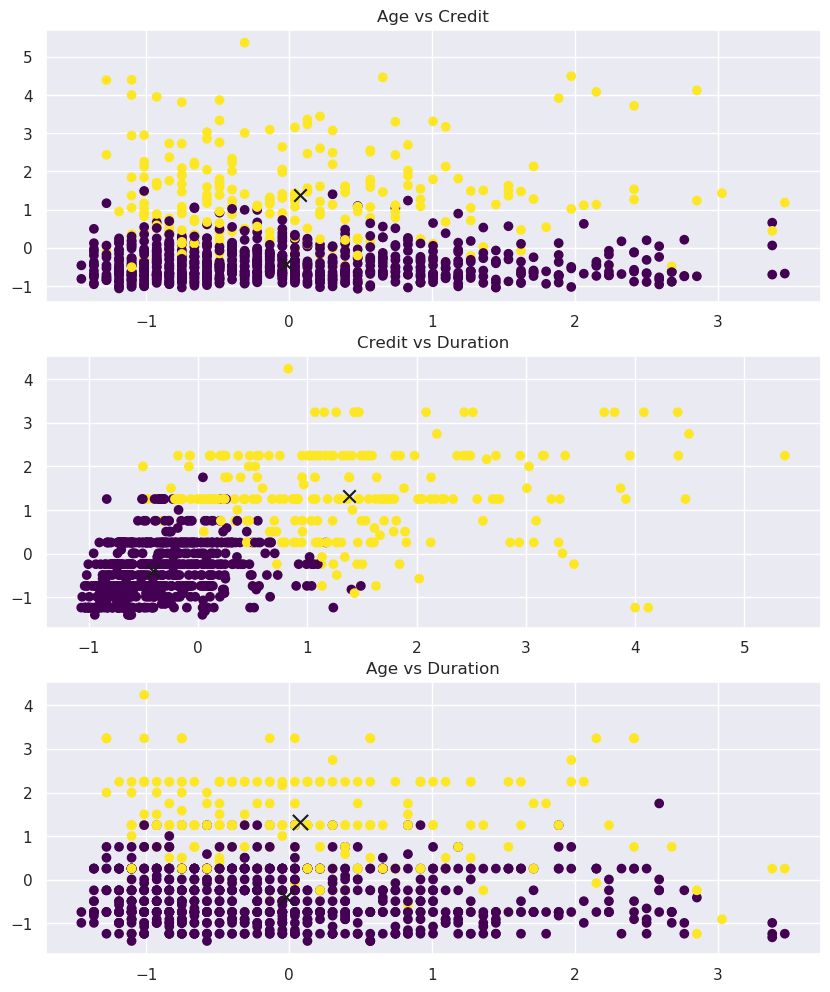

In [109]:
plt.figure(figsize=(10, 12))
plt.subplot(311)
plt.scatter(scaled_credit[:, 2], scaled_credit[:, 1], c=kmeans.labels_, cmap="viridis")
plt.scatter(
    kmeans.cluster_centers_[:, 2],
    kmeans.cluster_centers_[:, 1],
    s=80,
    marker="x",
    color="k",
)
plt.title("Age vs Credit")
plt.subplot(312)
plt.scatter(scaled_credit[:, 1], scaled_credit[:, 0], c=kmeans.labels_, cmap="viridis")
plt.scatter(
    kmeans.cluster_centers_[:, 1],
    kmeans.cluster_centers_[:, 0],
    s=80,
    marker="x",
    color="k",
)
plt.title("Credit vs Duration")
plt.subplot(313)
plt.scatter(scaled_credit[:, 2], scaled_credit[:, 0], c=kmeans.labels_, cmap="viridis")
plt.scatter(
    kmeans.cluster_centers_[:, 2],
    kmeans.cluster_centers_[:, 0],
    s=120,
    marker="x",
    color="k",
)
plt.title("Age vs Duration")
plt.show()

## Conclusion 
In this notebook we have discussed why risk bucketing is necessary, and considered three different approaches to estimating the optimal number of risk buckets.

Having estimated the optimal number of risk buckets, we made use of K-Means clustering to split our observations between the target number of risk buckets.

The follow-on activity is to create models for estimating default risk for each risk bucket, with each model trained separately using the data corresponding to the corresponding risk bucket.